# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.plotting import plot_histograms


/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        # print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

16:25 madminer.analysis    INFO    Loading data from data/delphes_data_shuffled.h5
16:25 madminer.analysis    INFO    Found 1 parameters
16:25 madminer.analysis    INFO    Did not find nuisance parameters
16:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
16:25 madminer.analysis    INFO    Found 35 observables
16:25 madminer.analysis    INFO    Found 3635115 events
16:25 madminer.analysis    INFO      856510 signal events sampled from benchmark no-higgs
16:25 madminer.analysis    INFO      821845 signal events sampled from benchmark 0.8_k
16:25 madminer.analysis    INFO      922750 signal events sampled from benchmark sm
16:25 madminer.analysis    INFO      112840 signal events sampled from benchmark 1.2_k
16:25 madminer.analysis    INFO      807988 signal events sampled from benchmark 1.5_k
16:25 madminer.analysis    INFO      113182 signal events sampled from benchmark 1.35_k
16:25 madminer.analysis    INFO    Found morphing setup with 5 components
16:25 madmi

This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
# @TODO: Install the new madminer with user defined points for faster evaluation
grid_ranges = [(0., 2.)]
grid_resolutions = [51]

What luminosity (in inverse pb) are we talking about?

In [7]:
lumi = 138.*10**3 #36000.#1.

In [8]:
p_values = {}
mle = {}
col = {}

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [9]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    #hist_vars=["pt_j1"],
    hist_vars=["m4l"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_m4l"] = p_values_expected_histo
mle["Histogram_m4l"] = best_fit_expected_histo
col["Histogram_m4l"] = 'g'

00:04 madminer.limits      INFO    Generating Asimov data
00:04 madminer.limits      INFO    Expected events: 17.233476760694984
00:04 madminer.limits      INFO    Calculating p-values for 17.233476760694984 expected events in mode histo without rate information
00:04 madminer.limits      INFO    Setting up standard summary statistics
00:04 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:04 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:04 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:04 madminer.limits      INFO    Calculating p-values


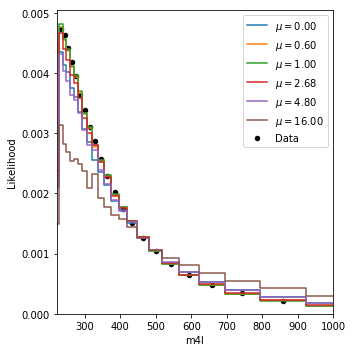

In [10]:
#indices = [12 + i * 25 for i in [6,9,12,15,18]]
#indices = [0,5,6,10,15,20]
#indices = [0,3,16,31,50]
#indices = [0,1,2,5,10]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    xlabel="m4l",
    xrange=(220.,1000.),
    #xrange=(0.,5.),
)

plt.show()



In [11]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    #hist_vars=["pt_j1"],
    hist_vars=["delta_eta_jj"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_dejj"] = p_values_expected_histo
mle["Histogram_dejj"] = best_fit_expected_histo
col["Histogram_dejj"] = 'orange'

00:04 madminer.limits      INFO    Generating Asimov data
00:04 madminer.limits      INFO    Expected events: 17.233476760694984
00:04 madminer.limits      INFO    Calculating p-values for 17.233476760694984 expected events in mode histo without rate information
00:04 madminer.limits      INFO    Setting up standard summary statistics
00:04 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:04 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:04 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:04 madminer.limits      INFO    Calculating p-values


In [12]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    #hist_vars=["delta_eta_jj"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_ptj1"] = p_values_expected_histo
mle["Histogram_ptj1"] = best_fit_expected_histo
col["Histogram_ptj1"] = 'b'

00:04 madminer.limits      INFO    Generating Asimov data
00:04 madminer.limits      INFO    Expected events: 17.233476760694984
00:04 madminer.limits      INFO    Calculating p-values for 17.233476760694984 expected events in mode histo without rate information
00:04 madminer.limits      INFO    Setting up standard summary statistics
00:04 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:04 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:04 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:04 madminer.limits      INFO    Calculating p-values


With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

Let's visualize the likelihood estimated with these histograms:

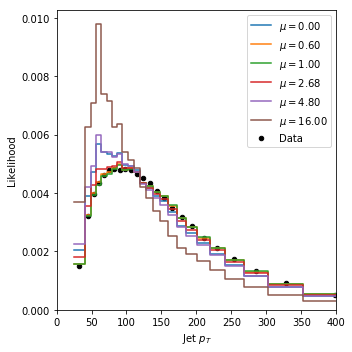

In [13]:
#indices = [12 + i * 25 for i in [6,9,12,15,18]]
#indices = [0,5,6,10,15,20]
#indices = [0,3,16,31,50]
#indices = [0,1,2,5,10]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    xlabel="Jet $p_T$",
    xrange=(0.,400.),
    #xrange=(0.,5.),
)

plt.savefig("Histogram_ptj1_training.pdf")
plt.show()


## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [14]:
theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices
col["ALICES"] = 'k'

00:04 madminer.limits      INFO    Generating Asimov data
00:04 madminer.limits      INFO    Expected events: 17.233476760694984
00:04 madminer.limits      INFO    Calculating p-values for 17.233476760694984 expected events in mode ml without rate information
00:04 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
00:04 madminer.ml          INFO    Loading model from models/alices
00:04 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
00:04 madminer.ml          INFO    Loading evaluation data
00:04 madminer.ml          INFO    Starting ratio evaluation for 9426432 x-theta combinations
00:08 madminer.ml          INFO    Evaluation done
00:08 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [12]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[1.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    #hist_bins=[[0.,5.,10.,15., 20.,25., 30.,35., 40., 45., 50.,55., 80., 100.]],
    #hist_bins=[[0.,10., 20., 30., 40., 50., 80., 100.]],
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally
col["SALLY"] = 'r'

19:48 madminer.limits      INFO    Generating Asimov data
19:48 madminer.limits      INFO    Expected events: 4.495689589746518
19:48 madminer.limits      INFO    Calculating p-values for 4.495689589746518 expected events in mode sally without rate information
19:48 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
19:48 madminer.ml          INFO    Loading model from models/sally
19:48 madminer.ml          INFO    Starting score evaluation
19:48 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
19:48 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
19:48 madminer.ml          INFO    Starting score evaluation
19:48 madminer.ml          INFO    Starting score evaluation
19:48 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
19:48 madminer.limits      INFO    Calculating p-values


Let's have a look at the underlying 2D histograms:

In [ ]:
#indices = [12 + i * 25 for i in [0,6,12,18,24]]
#indices = [0,15,25,35,40,50]
#indices = [0,3,16,31,50]
#indices = [0,1,2,3,5,10]
#indices = [0,10,15,20,30]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    #observed=observed[0,:100,:],
    #observed_weights=observed_weights[:100],
    observed=observed[0,:,:],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    #xlabel=r'$\hat{t}_0(x)$',
    #ylabel=r'$\hat{t}_1(x)$',
    xrange=(-0.3,0.3),
    yrange=(1.,4.5),
    log=True,
    #zrange=(1.e-3,1.),
    markersize=10.
)
    

## 6. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [16]:
signal_theta = 5**0.25
#signal_theta = 0.5**0.25
#signal_theta = 4.0**0.25
signal_theta

1.4953487812212205

In [17]:
theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[signal_theta],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    test_split=0.5
)

p_values["ALICES signal"] = p_values_expected_alices
mle["ALICES signal"] = best_fit_expected_alices
col["ALICES signal"] = "k"

00:08 madminer.limits      INFO    Generating Asimov data
00:08 madminer.limits      INFO    Expected events: 21.417262047016347
00:08 madminer.limits      INFO    Calculating p-values for 21.417262047016347 expected events in mode ml without rate information
00:08 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
00:08 madminer.ml          INFO    Loading model from models/alices
00:08 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
00:08 madminer.ml          INFO    Loading evaluation data
00:08 madminer.ml          INFO    Starting ratio evaluation for 20591913 x-theta combinations
00:18 madminer.ml          INFO    Evaluation done
00:18 madminer.limits      INFO    Calculating p-values


In [18]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[signal_theta],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["SALLY signal"] = p_values_expected_sally
mle["SALLY signal"] = best_fit_expected_sally
col["SALLY signal"] = "r"

00:18 madminer.limits      INFO    Generating Asimov data
00:18 madminer.limits      INFO    Expected events: 21.417262047016347
00:18 madminer.limits      INFO    Calculating p-values for 21.417262047016347 expected events in mode sally without rate information
00:18 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
00:18 madminer.ml          INFO    Loading model from models/sally
00:18 madminer.ml          INFO    Starting score evaluation
00:18 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:18 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:18 madminer.ml          INFO    Starting score evaluation
00:18 madminer.ml          INFO    Starting score evaluation
00:18 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:18 madminer.limits      INFO    Calculating p-values


In [19]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    #hist_vars=["pt_j1"],
    hist_vars=["m4l"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[signal_theta],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_m4l signal"] = p_values_expected_histo
mle["Histogram_m4l signal"] = best_fit_expected_histo
col["Histogram_m4l signal"] = "g"

00:18 madminer.limits      INFO    Generating Asimov data
00:18 madminer.limits      INFO    Expected events: 21.417262047016347
00:18 madminer.limits      INFO    Calculating p-values for 21.417262047016347 expected events in mode histo without rate information
00:18 madminer.limits      INFO    Setting up standard summary statistics
00:18 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:18 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:18 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:18 madminer.limits      INFO    Calculating p-values


In [20]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[signal_theta],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_ptj1 signal"] = p_values_expected_histo
mle["Histogram_ptj1 signal"] = best_fit_expected_histo
col["Histogram_ptj1 signal"] = "b"

00:18 madminer.limits      INFO    Generating Asimov data
00:18 madminer.limits      INFO    Expected events: 21.417262047016347
00:18 madminer.limits      INFO    Calculating p-values for 21.417262047016347 expected events in mode histo without rate information
00:18 madminer.limits      INFO    Setting up standard summary statistics
00:18 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:18 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:18 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:18 madminer.limits      INFO    Calculating p-values


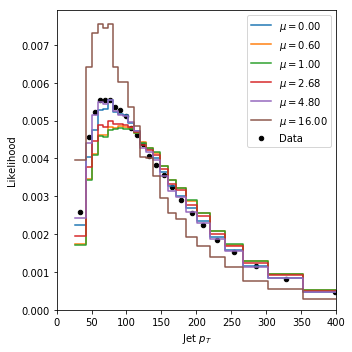

In [21]:
#indices = [12 + i * 25 for i in [6,9,12,15,18]]
#indices = [0,5,6,10,15,20]
#indices = [0,3,16,31,50]
#indices = [0,1,2,5,10]
indices = [0,22,25,32,37,50]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\mu = {:.2f}$".format(theta_grid[i,0]**4) for i in indices],
    xlabel="Jet $p_T$",
    xrange=(0.,400.),
    #xrange=(0.,5.),
)

plt.show()



In [22]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
    mode="histo",
    #hist_vars=["pt_j1"],
    hist_vars=["delta_eta_jj"],
    #hist_vars=["pt_j1", "delta_eta_jj"],
    #hist_bins=[[0.,40.,60.,80.,100.,150.,200.,300.,400.,1000.]],
    #hist_bins=[[0.,40.,80.,100.,150.,200.,300.,400.,1000.]],
    theta_true=[signal_theta],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    return_asimov=True,
    test_split=0.5
)

p_values["Histogram_dejj signal"] = p_values_expected_histo
mle["Histogram_dejj signal"] = best_fit_expected_histo
col["Histogram_dejj signal"] = "orange"

00:18 madminer.limits      INFO    Generating Asimov data
00:18 madminer.limits      INFO    Expected events: 21.417262047016347
00:18 madminer.limits      INFO    Calculating p-values for 21.417262047016347 expected events in mode histo without rate information
00:18 madminer.limits      INFO    Setting up standard summary statistics
00:18 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
00:18 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
00:18 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
00:18 madminer.limits      INFO    Calculating p-values


## Plot

Let's plot the results:

b
[1.] Histogram_ptj1
k
[1.] ALICES
orange
[1.] Histogram_dejj
g
[1.16985856] Histogram_m4l


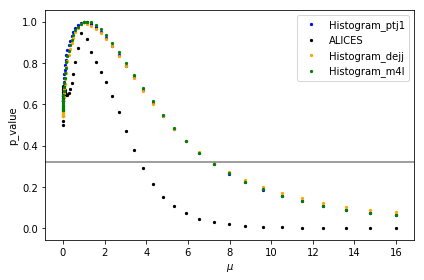

In [15]:
#show = "ALICES"
cmin, cmax = 1.e-3, 1.

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") != -1):
        continue
    #plt.scatter(centers**2, p_value, label=label)
    plt.scatter(centers**4, p_value, label=label, s=5, color=col[label])
    print (theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )
plt.axhline(y=0.32, color='grey', linestyle='-')
plt.legend()

#plt.xlabel(r'$\theta_0$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'p_value')
#plt.xlim(0,6)
#plt.ylim(0.4,1.03)

plt.tight_layout()
#plt.savefig("Histogram_m4l_muSM.pdf")
plt.show()



In [ ]:
p_values["ALICES"][25], p_values["ALICES"].max()

[0.12] [0.00020736] Histogram_m4l signal
[1.52] [5.33794816] SALLY signal
[1.52] [5.33794816] Histogram_ptj1 signal
[1.48] [4.79785216] Histogram_dejj signal
[1.48] [4.79785216] ALICES signal


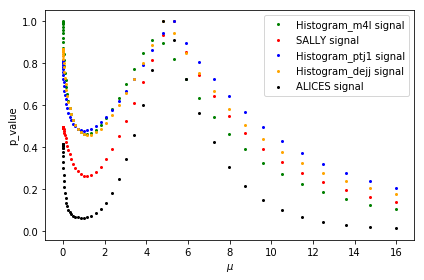

In [23]:
bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") == -1):
        continue
    plt.scatter(centers**4, p_value, label=label, s=4, color=col[label])
    print (theta_grid[mle[label]],theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]][0], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )
#plt.axhline(y=0.32, color='grey', linestyle='-')
plt.legend()

#plt.xlabel(r'$\theta_0$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'p_value')

plt.tight_layout()
#plt.savefig("Histogram_m4l_mu0p5.pdf")
plt.show()




In [64]:
p_values["ALICES signal"]

array([0.78082154, 0.7934764 , 0.80509493, 0.81458129, 0.82065831,
       0.82206342, 0.8178834 , 0.80784252, 0.79235698, 0.77233467,
       0.74888066, 0.72310275, 0.69602098, 0.66855409, 0.64152668,
       0.61568068, 0.59167726, 0.57008166, 0.55133872, 0.53574133,
       0.52339735, 0.514228  , 0.50802002, 0.50456542, 0.50389512,
       0.50653882, 0.51369212, 0.52716816, 0.54909416, 0.58142454,
       0.62541786, 0.68123591, 0.74782035, 0.82312772, 0.90470751,
       1.        , 0.925941  , 0.83990479, 0.75604088, 0.67524565,
       0.59845947, 0.5265217 , 0.46011709, 0.39973583, 0.34564091,
       0.29786361, 0.25622347, 0.22036868, 0.18982564, 0.16405029,
       0.14247359])

[0.4] [0.0256] Histogram_m4l signal
[1.4] [3.8416] SALLY signal
[1.4] [3.8416] ALICES signal
[0.48] [0.05308416] Histogram_ptj1 signal
[1.4] [3.8416] Histogram_dejj signal


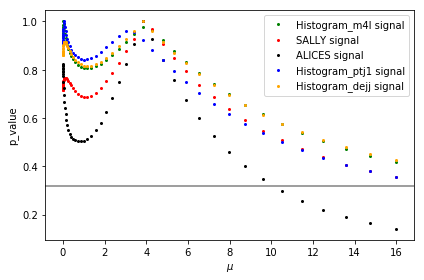

In [73]:
bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    if (label.find("signal") == -1):
        continue
    plt.scatter(centers**4, p_value, label=label, s=4, color=col[label])
    print (theta_grid[mle[label]],theta_grid[mle[label]]**4, label)
#     plt.scatter(
#         theta_grid[mle[label]][0], theta_grid[mle[label]][1],
#         s=80., color='C{}'.format(i), marker='*',
#         label=label
#     )
plt.axhline(y=0.32, color='grey', linestyle='-')
plt.legend()

plt.xlabel(r'$\mu$')
#plt.xlabel(r'$\mu$')
plt.ylabel(r'p_value')

plt.tight_layout()
#plt.savefig("MLvsHisto_mu0p5.pdf")
plt.show()



